In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
current_pwd = os.getcwd()

possible_paths = [
    '/home/export/soheuny/SRFinder/soheun/notebooks', 
    '/home/soheuny/HH4bsim/soheun/notebooks'
]
    
assert os.getcwd() in possible_paths, f"Did you change the path? It should be one of {possible_paths}"
os.chdir("..")

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import torch

from plots import hist_events_by_labels
from events_data import EventsData
from fvt_classifier import FvTClassifier


features = [
    "sym_Jet0_pt", "sym_Jet1_pt", "sym_Jet2_pt", "sym_Jet3_pt",
    "sym_Jet0_eta", "sym_Jet1_eta", "sym_Jet2_eta", "sym_Jet3_eta",
    "sym_Jet0_phi", "sym_Jet1_phi", "sym_Jet2_phi", "sym_Jet3_phi",  
    "sym_Jet0_m", "sym_Jet1_m", "sym_Jet2_m", "sym_Jet3_m",
]

In [28]:
import numpy as np
import torch
from fvt_classifier import FvTClassifier
from tst_info import TSTInfo
import matplotlib.pyplot as plt
from events_data import events_from_scdinfo
from training_info import TrainingInfoV2
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split
from smearing import AttentionClassifier

n_3b = 100_0000
device = torch.device("cuda")
experiment_name = "counting_test_v1"
signal_filename = "HH4b_picoAOD.h5"
ratio_4b = 0.5
seed = 0

noise_scale = 0.02

hparams_filter = {
    "n_3b": n_3b,
    "signal_ratio": 0.02,
    "experiment_name": experiment_name,
    "seed": seed,
}
hashes = TSTInfo.find(hparams_filter)
tst_hash = hashes[0]

tst_info = TSTInfo.load(tst_hash)

def smear_features(X: np.ndarray, noise_scale: float):
    features_min = np.min(X, axis=0)
    features_max = np.max(X, axis=0)
    base_scale = features_max - features_min
    
    accept_mask = np.zeros_like(X, dtype=bool)
    X_smeared = np.zeros_like(X)
    while True:
        X_smeared[~accept_mask] = (X + noise_scale * base_scale * np.random.randn(*X.shape))[~accept_mask]
        accept_mask = (X_smeared >= features_min) & (X_smeared <= features_max)
        if np.all(accept_mask):
            break
        
    return X_smeared



base_fvt_tinfo = TrainingInfoV2.load(tst_info.base_fvt_tinfo_hash)
events_base = events_from_scdinfo(base_fvt_tinfo.scdinfo, features, signal_filename)
# get 4b events
is_4b = events_base.is_4b
events_base_4b = events_base[is_4b]

# split events_base_4b to orig and smeared
events_base_4b_orig, events_base_4b_smeared = events_base_4b.split(0.5, seed=seed)

# smear features
print(f"noise_scale: {noise_scale}")
X_smeared_base_4b = smear_features(events_base_4b_smeared.X, noise_scale)
# merge orig and smeared
X_4b = np.concatenate([events_base_4b_orig.X, X_smeared_base_4b], axis=0)
is_smeared = np.concatenate([np.zeros_like(events_base_4b_orig.is_4b), np.ones_like(events_base_4b_smeared.is_4b)])
w_4b = np.concatenate([events_base_4b_orig.weights, events_base_4b_smeared.weights], axis=0)

X_4b_train, X_4b_val, w_4b_train, w_4b_val, is_smeared_train, is_smeared_val = train_test_split(
    X_4b, w_4b, is_smeared, test_size=1/3, random_state=seed
)

# fit batch size
batch_size = 1024
X_4b_train = X_4b_train[len(X_4b_train) % batch_size:]
X_4b_val = X_4b_val[len(X_4b_val) % batch_size:]
w_4b_train = w_4b_train[len(w_4b_train) % batch_size:]
w_4b_val = w_4b_val[len(w_4b_val) % batch_size:]
is_smeared_train = is_smeared_train[len(is_smeared_train) % batch_size:]
is_smeared_val = is_smeared_val[len(is_smeared_val) % batch_size:]

ovs_model = FvTClassifier(
        num_classes=2,
        dim_input_jet_features=4,
        dim_dijet_features=6,
        dim_quadjet_features=6,
        run_name="",
        device=torch.device("cuda:0"),
        lr=1e-3,
    )

# train 4b / 4b smeared
ovs_model.fit(
    TensorDataset(torch.tensor(X_4b_train, dtype=torch.float32), 
                torch.tensor(is_smeared_train, dtype=torch.long),
                torch.tensor(w_4b_train, dtype=torch.float32)),
    TensorDataset(torch.tensor(X_4b_val, dtype=torch.float32),
                torch.tensor(is_smeared_val, dtype=torch.long),
                torch.tensor(w_4b_val, dtype=torch.float32)),
    batch_size=1024,
    max_epochs=10,
    train_seed=seed,
    save_checkpoint=False
)

# Get predictions on validation set
ovs_model.eval()
ovs_model.to(device)

events_tst = events_from_scdinfo(tst_info.scdinfo_tst, features, signal_filename)
events_tst_4b = events_tst[events_tst.is_4b]
events_tst_4b_orig, events_tst_4b_smeared = events_tst_4b.split(0.5, seed=seed)

is_smeared_tst = np.concatenate([np.zeros_like(events_tst_4b_orig.is_4b), np.ones_like(events_tst_4b_smeared.is_4b)])
X_smeared_tst_4b = smear_features(events_tst_4b_smeared.X, noise_scale)
X_tst = np.concatenate([events_tst_4b_orig.X, X_smeared_tst_4b], axis=0)

noise_scale: 0.02


[rank: 0] Seed set to 0
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
----------------------------------------
895       Trainable params
49        Non-trainable params
944       Total params
0.004     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 534/534 [00:31<00:00, 16.91it/s, v_num=237, val_loss=0.434, train_loss=0.459]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 534/534 [00:31<00:00, 16.84it/s, v_num=237, val_loss=0.434, train_loss=0.459]


AssertionError: 

In [29]:
with torch.no_grad():
    probs_est_smeared_tst = ovs_model.predict(
        torch.tensor(X_tst, dtype=torch.float32).to(ovs_model.device)).detach().cpu().numpy()[:, 1]

In [37]:
ovs_repr_classifier = AttentionClassifier(
    input_size=6,
    num_classes=2,
    learning_rate=1e-3,
    random_state=seed)

base_fvt_model = FvTClassifier.load_from_checkpoint(f"./data/checkpoints/{tst_info.base_fvt_tinfo_hash}_best.ckpt")
base_fvt_model.eval()
base_fvt_model.to(device)

events_tst_4b_orig.set_model_scores(base_fvt_model)
events_tst_4b_smeared.set_model_scores(base_fvt_model)

q_repr_smeared_tst = smear_features(events_tst_4b_smeared.q_repr, 0.1)
q_repr_tst = np.concatenate([events_tst_4b_orig.q_repr, q_repr_smeared_tst], axis=0)
is_smeared_tst = np.concatenate([np.zeros_like(events_tst_4b_orig.is_4b), np.ones_like(events_tst_4b_smeared.is_4b)])
w_tst = np.concatenate([events_tst_4b_orig.weights, events_tst_4b_smeared.weights], axis=0)

# train a classifier on att_q_repr
ovs_repr_classifier.fit(q_repr_tst, is_smeared_tst, w_tst)

# Get predictions on validation set
ovs_repr_classifier.eval()
ovs_repr_classifier.to(device)

/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 9: 100%|██████████| 133/133 [00:04<00:00, 27.82it/s, avg_val_loss=0.438]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 133/133 [00:04<00:00, 27.81it/s, avg_val_loss=0.438]


AttentionClassifier(
  (select_q): conv1d(
    (module): Conv1d(6, 1, kernel_size=(1,), stride=(1,), bias=False)
    (batchNorm): GhostBatchNorm1d()
  )
  (out): conv1d(
    (module): Conv1d(6, 2, kernel_size=(1,), stride=(1,), bias=False)
    (batchNorm): GhostBatchNorm1d()
  )
)

In [38]:
probs_est_smeared_tst_v2 = ovs_repr_classifier.predict(q_repr_tst)[:, 1]

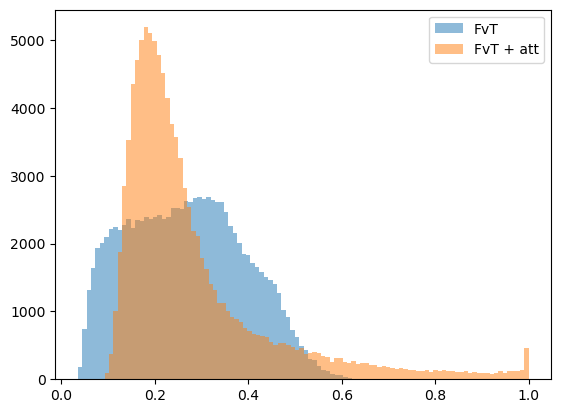

In [41]:
plt.hist(probs_est_smeared_tst[~is_smeared_tst], bins=100, alpha=0.5, label="FvT")
plt.hist(probs_est_smeared_tst_v2[~is_smeared_tst], bins=100, alpha=0.5, label="FvT + att")
plt.legend()
plt.show()
plt.close()



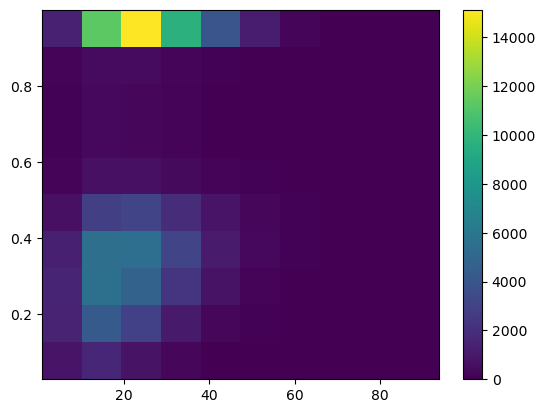

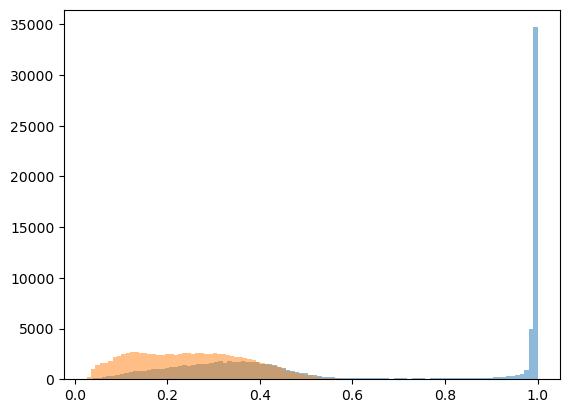

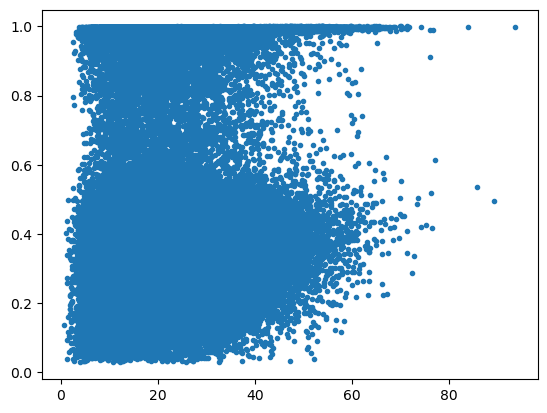

In [14]:
noise_norms = np.linalg.norm(X_smeared_tst_4b - events_tst_4b_smeared.X, axis=1)

fig, ax = plt.subplots()
plt.hist2d(noise_norms, probs_est_smeared_tst[is_smeared_tst], bins=10)
plt.colorbar()
plt.show()
plt.close()

fig, ax = plt.subplots()
plt.hist(probs_est_smeared_tst[is_smeared_tst], bins=100, alpha=0.5, label="smeared")
plt.hist(probs_est_smeared_tst[~is_smeared_tst], bins=100, alpha=0.5, label="orig")
plt.show()
plt.close()

plt.plot(noise_norms, probs_est_smeared_tst[is_smeared_tst], '.')
plt.show()
plt.close()



In [25]:
base_fvt_model = FvTClassifier.load_from_checkpoint(f"./data/checkpoints/{tst_info.base_fvt_tinfo_hash}_best.ckpt")
base_fvt_model.eval()
base_fvt_model.to(device)

events_tst_4b_smeared.set_model_scores(base_fvt_model)
events_tst_4b_orig.set_model_scores(base_fvt_model)

In [26]:
smeared_att_q_repr = smear_features(events_tst_4b_smeared.att_q_repr, noise_scale)

